## 국회의원 현황정보 수집 분석 시각화 저장
* 이름과 id 추출
* 상세페이지 정보 추출(json저장)
* 상세정보들을 DataFrame으로 변환

In [14]:
import requests
from bs4 import BeautifulSoup
import re

##국회의원 페이지는 ajax 통신을 통해 함
url = 'https://www.assembly.go.kr/assm/memact/congressman/memCond/memCondListAjax.do'
req_param_dict = {
    'currentPage':1,
    'rowPerPage':500

}

res = requests.get(url,params=req_param_dict)
# print(res.status_code)

if res.ok:
    soup = BeautifulSoup(res.text,'html.parser')
    # print(len(soup.select('div.memberna_list dl dt a'))) #div -> dl -> dt -> a 순서로 내려감
    atag_list = soup.select('div.memberna_list dl dt a')
    member_id_list = []
    for atag in atag_list:
        href = atag['href'] #javascript:jsMemPop('9771230') #regexr.com 으로 고고 #내용 붙여넣어서 정규표현식 찾음
        # print(href)
        matched = re.search(r'(\d+)',href)
        # print(matched.group(0))
        if matched:
            member_id = matched.group(0) #국회의원 번호를 찾음
        member_id_list.append(member_id)
    print(len(member_id_list))
    print(member_id_list[:3])




295
['9771230', '9771142', '9771174']


In [47]:
import requests
from bs4 import BeautifulSoup
import re
from urllib.parse import urljoin  ##사진을 위해

print('--> 스크래핑 시작')
member_detail_list = [] #국회의원 상세정보를 위한 list

for idx,mem_id in enumerate(member_id_list,1):
    detail_url = f'https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd={mem_id}'
    print(idx,detail_url)
    res = requests.get(detail_url)
    if res.ok:
        soup = BeautifulSoup(res.text,'html.parser')
        # print(soup)

        #1명의 정보를 저장할 dict 선언
        member_detail_dict = {}
        #국회의원 소개 페이지에서 오른쪽에 (정당,선거구,소속위원회..) = 1개리스트 | (국민의힘,대구 동구을,,,) = 1개 리스트 해서 하나로 합친다(zip)
        #dt 태그와 dd 태그 존재
        # print(len(soup.select('dl.pro_detail dt')))
        # print(len(soup.select('dl.pro_detail dd')))




        dt_list = []
        dd_list = []

        for dt_tag in soup.select('dl.pro_detail dt'):

            pattern = re.compile(f'[\n\r\t]') #특수문자 제거를 위한 패턴을 만듬
            dt_text = pattern.sub('',dt_tag.text.strip())
            dt_list.append(dt_text)

        # print(dt_list)
        for dd_tag in soup.select('dl.pro_detail dd'):
            dd_text = pattern.sub('',dd_tag.text.strip()).replace(" ","") ##중간에 빈공백이 남아있어서 중간에 있는 빈 공백을 제거한다 replace(찾을거,대체할거)
            dd_list.append(dd_text)
        # print(dd_list)

        member_detail_dict = dict(zip(dt_list,dd_list)) #dt태그 list와 dd태그 list를 딕셔너리에 zip함수로 묶는다


        for div_tag in soup.select('div.profile'):
            # print(div_tag.find('h4').text) ###태그 밑에있는 태그를 찾을때 find함수 사용
            member_detail_dict['이름'] = div_tag.find('h4').text #딕셔너리에 이름 이라는 태그로 넣기

            img_tag = div_tag.select('img')


            if img_tag:
                # member_detail_dict['이미지'] = img_tag_list[0]
                # print(img_tag[0]['src'])
                member_detail_dict['이미지'] = urljoin(detail_url,img_tag[0]['src']) ##이미지태그에서 src 값을 딕셔너리에 넣는다.
                                                                                    ## urljoin을 안써도 되지만 src값이 없는경우를 대비해서 안전하게 함!
            # print(div_tag.select_one('li:nth-of-type(4)').text) ##css selector nth-of-type : filter 해주는거
            member_detail_dict['생년월일'] = div_tag.select_one('li:nth-of-type(4)').text
        member_detail_list.append(member_detail_dict) #1명이 저장되어있는 member_detail_dict를 member_detail_list에 추가합니다.
        # print(member_detail_dict)

print(len(member_detail_list))
print('--->스크래핑 끝')



--> 스크래핑 시작
1 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771230
2 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771142
3 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771174
4 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771233
5 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771283
6 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9770933
7 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771116
8 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771276
9 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771168
10 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771007
11 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771109
12 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771180
13 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9770931
14 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771224
15 https://www.as

## json으로 만들어서 DataFrame으로 만들기

In [49]:
import json

with open('data/member.json','w') as file: #파일만들기
    json.dump(member_detail_list,file,ensure_ascii=False)  #member_detail_list를 json파일로 만듬

In [50]:
import pandas as pd

members_df = pd.read_json('data/member.json')
print(members_df.shape)

(295, 16)


In [52]:
members_df['정당']

0        국민의힘
1        국민의힘
2      더불어민주당
3        국민의힘
4      더불어민주당
        ...  
290    더불어민주당
291      국민의힘
292      국민의힘
293    더불어민주당
294    더불어민주당
Name: 정당, Length: 295, dtype: object

In [53]:
members_df['정당'].value_counts() #정당별 count

더불어민주당    172
국민의힘      106
정의당         6
무소속         6
국민의당        3
기본소득당       1
시대전환        1
Name: 정당, dtype: int64

In [54]:
members_df['당선횟수'].value_counts() #몇번당선됐나?

초선(21대)                        149
재선(20대,21대)                     60
3선(19대,20대,21대)                 33
4선(17대,19대,20대,21대)             10
재선(19대,21대)                      9
5선(17대,18대,19대,20대,21대)          7
4선(18대,19대,20대,21대)              6
3선(18대,19대,21대)                  3
재선(17대,21대)                      2
4선(16대,17대,18대,21대)              2
5선(16대,17대,18대,20대,21대)          2
3선(17대,19대,21대)                  2
3선(18대,20대,21대)                  2
4선(17대,18대,19대,21대)              1
3선(15대,16대,21대)                  1
6선(16대,17대,18대,19대,20대,21대)      1
5선(16대,17대,18대,19대,21대)          1
5선(15대,16대,19대,20대,21대)          1
3선(17대,18대,21대)                  1
재선(18대,21대)                      1
5선(15대,16대,17대,18대,21대)          1
Name: 당선횟수, dtype: int64

In [55]:
members_df['선거구'].value_counts()

비례대표              47
경남창원시성산구           1
광주광산구갑             1
전남담양군함평군영광군장성군     1
강원원주시갑             1
                  ..
경남창원시의창구           1
충남천안시을             1
서울강북구을             1
부산남구을              1
서울양천구갑             1
Name: 선거구, Length: 249, dtype: int64

In [58]:
##당선횟수2 칼럼을 새로 추가 재선(20대,21대) -> 재선 으로 만들것임

print(type(members_df['당선횟수'])) #<class 'pandas.core.series.Series'>
print(type(members_df['당선횟수'].str)) #<class 'pandas.core.strings.accessor.StringMethods'>

#series객체를 stringmethod 객체로 변환해야한다 -> 문자열 슬라이싱을 하기 위해
temp_str = members_df['당선횟수'].str
members_df['당선횟수2'] = temp_str[:2] #members_df에 당선횟수2 컬럼을 만들고 stringmethod로 변환된 temp_str에 두글자만 자름

members_df['당선횟수2'].head(2)

members_df.loc[0:3,['당선횟수','당선횟수2']]

<class 'pandas.core.series.Series'>
<class 'pandas.core.strings.accessor.StringMethods'>


,당선횟수,당선횟수2
0,"재선(19대,21대)",재선
1,초선(21대),초선
2,초선(21대),초선
3,초선(21대),초선


In [59]:
members_df['당선횟수2'].value_counts()

초선    149
재선     72
3선     42
4선     19
5선     12
6선      1
Name: 당선횟수2, dtype: int64

In [60]:
members_df.loc[members_df['당선횟수2'] == '6선'] #6선인사람 검색

,정당,선거구,소속위원회,당선횟수,사무실 전화,사무실 호실,홈페이지,이메일,보좌관,비서관,비서,"취미, 특기",의원실 안내,이름,이미지,생년월일,당선횟수2
91,무소속,대전서구갑,,"6선(16대,17대,18대,19대,20대,21대)",02-6788-6461,의원회관804호,,pbs2100@gmail.com,"박승규,송석근","김민숙,좌승택","이영해,조연길,최지연,임규보,이초롱",,,박병석,https://www.assembly.go.kr/photo/9770090.jpg,1952-01-25,6선


In [61]:
sun_2 = members_df['선거구'].str
members_df['선거구2'] = sun_2[:2]
members_df.head(2)


,정당,선거구,소속위원회,당선횟수,사무실 전화,사무실 호실,홈페이지,이메일,보좌관,비서관,비서,"취미, 특기",의원실 안내,이름,이미지,생년월일,당선횟수2,선거구2
0,국민의힘,경남창원시성산구,보건복지위원회,"재선(19대,21대)",02-784-1751,의원회관937호,http://blog.naver.com/ggotop,ggotop@naver.com,"김홍광,한영애","지상훈,최광림","김영록,안효상,이유진,홍지형,김지훈",,,강기윤,https://www.assembly.go.kr/photo/9771230.jpg,1960-06-04,재선,경남
1,국민의힘,대구동구을,"국방위원회,정치개혁특별위원회",초선(21대),02-784-5275,의원회관341호,,kds21341@naver.com,"박홍규,정운태","유진영,윤미라","박순권,김광연,김현정,송민욱",,,강대식,https://www.assembly.go.kr/photo/9771142.jpg,1959-11-02,초선,대구


In [62]:
members_df['선거구2'].value_counts()

경기    58
비례    47
서울    47
부산    18
경남    16
경북    13
인천    13
충남    11
대구    11
전북    10
전남    10
광주     8
강원     8
충북     7
대전     7
울산     6
제주     3
세종     2
Name: 선거구2, dtype: int64

In [63]:
members_df['생년월일'].head(3)

0    1960-06-04
1    1959-11-02
2    1963-05-27
Name: 생년월일, dtype: object

https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html

In [68]:
#DatetimeIndex 객체를 사용해서 생년월일 컬럼의 값을 year,month,day로 각각 추출한다.
## year,month,day 3개의 컬럼을 새로 추가한다.
members_df['year'] = pd.DatetimeIndex(members_df['생년월일']).year
members_df['month'] = pd.DatetimeIndex(members_df['생년월일']).month
members_df['day'] = pd.DatetimeIndex(members_df['생년월일']).day

members_df.loc[0:3,['year','month','day']]

,year,month,day
0,1960,6,4
1,1959,11,2
2,1963,5,27
3,1971,3,3


In [74]:
members_df['year'].min()

members_df.loc[members_df['year'] == members_df['year'].max()]  #나이가 가장어린사람은 year(출생년)이 가장 높은것과 같을때

members_df.loc[members_df['year'] == members_df['year'].max(),['이름','정당']]

,이름,정당
79,류호정,정의당


In [76]:
#나이를 계산하는 함수 정의하기
from datetime import date

#인자로 받는 birth 객체는 datetime.date 객체입니다
def calc_age(birth):
    today = date.today()
    age = today.year - birth.year - ((today.month,today.day) < (birth.month,birth.day))
    return age

calc_age(date(1996,4,27))

25

In [85]:
#row별로 년,월,일 컬럼의 값을 나이를 계산해서 list에 넣는다.
#계산된 나이값을 age_list에 추가하기

age_list = []

for idx,row in members_df.iterrows():
    age = calc_age(date(row['year'],row['month'],row['day']))
    age_list.append(age)
members_df['나이'] = age_list

In [87]:
members_df[['생년월일','나이']]

,생년월일,나이
0,1960-06-04,61
1,1959-11-02,62
2,1963-05-27,58
3,1971-03-03,50
4,1961-04-26,60
...,...,...
290,1978-11-24,43
291,1954-12-05,67
292,1976-08-05,45
293,1962-09-10,59


In [88]:
members_df['나이'].describe()

count    295.000000
mean      56.667797
std        7.352968
min       29.000000
25%       54.000000
50%       58.000000
75%       61.000000
max       74.000000
Name: 나이, dtype: float64

### 시각화(visualization)
* Image 출력 - IPython에서 제공하는 Image 객체,display()
* seaborn -countplot, distplot
* matplotlib - histogram,pie chart
* 한글폰트 설정

In [89]:
from IPython.display import Image,display

for img_url in members_df['이미지'].sample(2):
    display(Image(url = img_url))

In [91]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'
font_prop = fm.FontProperties(fname=font_path).get_name()

matplotlib.rc('font',family = font_prop)



AppleGothic


### seaborn의 막대 그래프
* barplot - x축과 y축을 둘 다 설정할 수 있음
* countplot - x축이나 y축 중에서 하나만 설정할수 있음

In [92]:
members_df['정당'].value_counts()

더불어민주당    172
국민의힘      106
정의당         6
무소속         6
국민의당        3
기본소득당       1
시대전환        1
Name: 정당, dtype: int64

0    재선
1    초선
2    초선
Name: 당선횟수2, dtype: object


<AxesSubplot:xlabel='당선횟수2', ylabel='count'>

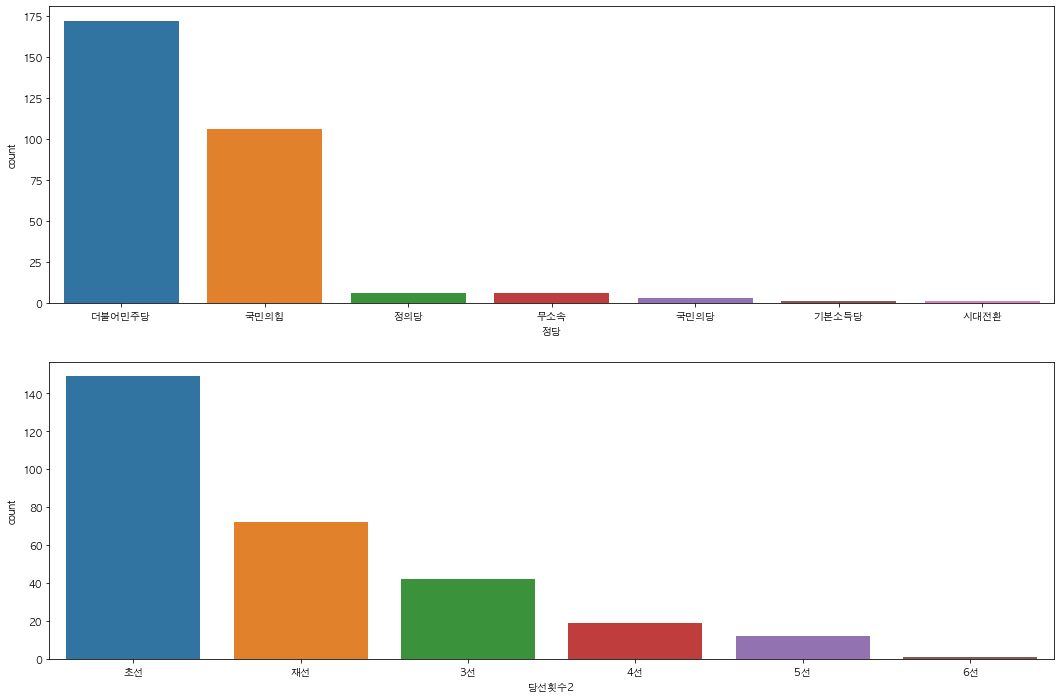

In [102]:
figure,(axes1,axes2) = plt.subplots(nrows=2,ncols=1)
figure.set_size_inches(18,12)

print(members_df['당선횟수2'].head(3))
sns.countplot(data = members_df,x = '정당',ax = axes1,order = members_df['정당'].value_counts().index) ##y축은 자동으로 count생성
sns.countplot(data = members_df,x = '당선횟수2',ax = axes2,order = members_df['당선횟수2'].value_counts().index)

